# NeuroMANCER: System ID Tutorial

This notebook outlines the basic structure of a training script for system identification with deep state space models.

We begin by importing the necessary components from NeuroMANCER, as well as specifying some hyperparameters used to define the structure and optimization of our model:

In [14]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import slim
import psl

from neuromancer import blocks, estimators, dynamics, arg
from neuromancer.activations import activations
from neuromancer.visuals import VisualizerOpen
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import Objective
from neuromancer.simulators import OpenLoopSimulator, MultiSequenceOpenLoopSimulator
from neuromancer.callbacks import SysIDCallback
from neuromancer.loggers import BasicLogger, MLFlowLogger
from neuromancer.dataset import read_file, normalize_data, split_sequence_data, SequenceDataset
from neuromancer.constraint import Variable


# params for configuration
params = {
    "nsteps": 32,             # Prediction horizon length.
    "nsim": 10000,            # Number of temporal datapoints in the simulated dataset.
    "data_seed": 408,         # Random seed for the dataset emulator.
    "norm": ["U", "D", "Y"],  # Norms imposed on raw variables. U: inputs, D: disturbances, Y: outputs.
    "Q_y": 1.0,               # Output tracking penalty weight.
    "Q_e": 1.0,               # State estimator hidden prediction penalty weight.
    "Q_sub": 1.0,             # Linear maps regularization weight.
    "Q_con_x": 1.0,           # Hidden state constraints penalty weight.
    "Q_dx": 0.1,              # Penalty weight on hidden state difference in one time step. 
    "savedir": "test",        # Where should your trained model and plots be saved (temp).
    "eval_metric": "loop_dev_ref_loss",   # Metric for model selection and early stopping.
    "metrics": ["nstep_dev_loss", "loop_dev_loss", "best_loop_dev_loss",
               "nstep_dev_ref_loss", "loop_dev_ref_loss"],   # Metrics to be logged.
    "epochs": 300,            # Number of training epochs.
    "lr": 0.001,              # Learning rate.
    "patience": 100,          # Early stopping patience.
    "warmup": 10,             # Early stopping warmup.
}
device = "cuda:0" if torch.cuda.is_available() else "cpu"

## Datasets
NeuroMANCER currently supports both static and emulated datasets (generated from governing equations for various systems) via [PSL](https://github.com/pnnl/psl). Here, we define get_sequence_dataloaders() function for generating dataloader from the raw  data given as dictionary.  
For more details see datasets tutorial.

In [15]:
def get_sequence_dataloaders(
    data, nsteps, moving_horizon=False, norm_type="zero-one", split_ratio=None, num_workers=0,
):
    """This will generate dataloaders and open-loop sequence dictionaries for a given dictionary of
    data. Dataloaders are hard-coded for full-batch training to match NeuroMANCER's original
    training setup.

    :param data: (dict str: np.array or list[dict str: np.array]) data dictionary or list of data
        dictionaries; if latter is provided, multi-sequence datasets are created and splits are
        computed over the number of sequences rather than their lengths.
    :param nsteps: (int) length of windowed subsequences for N-step training.
    :param moving_horizon: (bool) whether to use moving horizon batching.
    :param norm_type: (str) type of normalization; see function `normalize_data` for more info.
    :param split_ratio: (list float) percentage of data in train and development splits; see
        function `split_sequence_data` for more info.
    """

    data, _ = normalize_data(data, norm_type)
    train_data, dev_data, test_data = split_sequence_data(data, nsteps, moving_horizon, split_ratio)

    train_data = SequenceDataset(
        train_data,
        nsteps=nsteps,
        moving_horizon=moving_horizon,
        name="train",
    )
    dev_data = SequenceDataset(
        dev_data,
        nsteps=nsteps,
        moving_horizon=moving_horizon,
        name="dev",
    )
    test_data = SequenceDataset(
        test_data,
        nsteps=nsteps,
        moving_horizon=moving_horizon,
        name="test",
    )

    train_loop = train_data.get_full_sequence()
    dev_loop = dev_data.get_full_sequence()
    test_loop = test_data.get_full_sequence()

    train_data = DataLoader(
        train_data,
        batch_size=len(train_data),
        shuffle=False,
        collate_fn=train_data.collate_fn,
        num_workers=num_workers,
    )
    dev_data = DataLoader(
        dev_data,
        batch_size=len(dev_data),
        shuffle=False,
        collate_fn=dev_data.collate_fn,
        num_workers=num_workers,
    )
    test_data = DataLoader(
        test_data,
        batch_size=len(test_data),
        shuffle=False,
        collate_fn=test_data.collate_fn,
        num_workers=num_workers,
    )

    return (train_data, dev_data, test_data), (train_loop, dev_loop, test_loop), train_data.dataset.dims


In [17]:
# load dictionary dataset with raw data
# for available systems in PSL library check: psl.systems.keys()
# for available datasets in PSL library check: psl.datasets.keys()

system = 'aero'         # keyword of selected system

#  load raw dataset
if system in psl.emulators:
    data = psl.emulators[system](nsim=nsim, ninit=0, seed=args.data_seed).simulate()
elif system in psl.datasets:
    data = read_file(psl.datasets[system])
else:
    data = read_file(system)

usage: ipykernel_launcher.py [-h] [-dataset DATASET] [-nsteps NSTEPS]
                             [-nsim NSIM] [-norm {U,D,Y,X} [{U,D,Y,X} ...]]
                             [-data_seed DATA_SEED] [-Q_con_x Q_CON_X]
                             [-Q_dx Q_DX] [-Q_sub Q_SUB] [-Q_y Q_Y] [-Q_e Q_E]
                             [-savedir SAVEDIR] [-verbosity VERBOSITY]
                             [-metrics METRICS [METRICS ...]]
                             [-eval_metric EVAL_METRIC] [-epochs EPOCHS]
                             [-lr LR] [-patience PATIENCE] [-warmup WARMUP]
                             [-skip_eval_sim] [-seed SEED] [-device {cpu,gpu}]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\drgo694\AppData\Roaming\jupyter\runtime\kernel-ba6cbd27-c7fe-4399-a729-8fc418b9b1de.json


SystemExit: 2

Processed dataset format:  
nsim = number of time steps in the dataset time series  
nsteps = legth of the prediction horizon  
Y = observed outputs  
U = inputs  
D = disturbances  
Yp = past trajectories generated as Y[0:-nsteps]  
Yf = future trajectories generated as Y[nesteps:]  
data format in dataset dictionaries: train_data['key']: torch.Size([batch size (prediction horizon), number of batches, number of variables])

In [4]:
#  Train, Development, Test sets - nstep and loop format
nstep_data, loop_data, dims = get_sequence_dataloaders(data, params['nsteps'])
train_data, dev_data, test_data = nstep_data
train_loop, dev_loop, test_loop = loop_data

# input, output dimensions
nu = dims['U'][1]
ny = dims['Y'][1]

## State Estimator

To generate initial states during $N$-step training, we make use of state estimators which use the past outputs of the system to estimate the next state variable. NeuroMANCER provides a host of parametric state estimators for this purpose; in this case, we'll use a fully connected neural network. Each state estimator in neuromancer.estimators represents more generic component class representing arbitrary nn.Module with input_keys and output_keys for mapping neuromancer variabels.  
For more details see components and constraints tutorials.

In [5]:
activation = activations['relu']
linmap = slim.maps['linear']

nx = 90  # size of the latent variables
estimator = estimators.MLPEstimator(
    {**dims, "x0": (nx,)},
    nsteps=params['nsteps'],  # future window Nf
    window_size=params['nsteps'],  # past window Np <= Nf
    bias=True,
    linear_map=linmap,
    nonlin=activation,
    hsizes=[90, 120, 90],
    input_keys=["Yp"],
    linargs={},
    name='estimator',
)

# input output keys of the estimator 
print(estimator.input_keys)
print(estimator.output_keys)

# dynamics_model mapping of input keys to output keys
print(estimator)
# x0 = estimator(Yp)
# x0: initial values of latent variables estimated from time lagged outputs Yp

['Yp']
['x0_estimator', 'reg_error_estimator']
estimator(Yp) -> x0_estimator, reg_error_estimator


C:\Users\drgo694\AppData\Local\Continuum\anaconda3\envs\neuromancer\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## State Space Model

Next, we define our block-structured state space model (SSM) as neuromancer component. These models divide system dynamics into separate functional components to decouple the behaviors of inputs, state transitions, and outputs. Using the `BlockSSM` constructor, we can build SSMs with arbitrary components, each with their own nonlinearities and structured weight parameterizations.  
For more details on how to construct arbitrary acyclic computational graphs with see components tutorial.

In [6]:
# define blocks
fx = blocks.RNN(nx, nx, linear_map=linmap,
                nonlin=activations['softexp'], hsizes=[60, 60])
linargs = {"sigma_min": 0.5, "sigma_max": 1.0}
fy = slim.maps['softSVD'](nx, ny, linargs=linargs)
fu = blocks.MLP(nu, nx, hsizes=[60, 60]) if nu != 0 else None

# define state space model
dynamics_model = dynamics.BlockSSM(fx, fy, fu=fu, name='dynamics', xou=torch.add,
                                   input_keys={f"x0_{estimator.name}": "x0"})

# input output keys of the SSM 
print(dynamics_model.input_keys)
print(dynamics_model.output_keys)

# dynamics_model mapping of input keys to output keys
print(dynamics_model)
# Yf = dynamics_model(x0, Uf)
# Uf: future control actions
# Yf: predicted outputs

['Yf', 'x0_estimator', 'Uf']
['X_pred_dynamics', 'Y_pred_dynamics', 'reg_error_dynamics']
dynamics(Yf, x0_estimator, Uf) -> X_pred_dynamics, Y_pred_dynamics, reg_error_dynamics


## Neuromancer Variables
Here we leverage Neuromancer's variable abstraction for intuitive high-level definition of objective temrs and constraints. Each variable has assigned uniqye name that either exists as a key in the dataset dictionary (e.g., "Yf"), or is listed as output key in one of our components.

In [7]:
# bounds
xmin = -0.2
xmax = 1.2
dxudmin = -0.5
dxudmax = 0.5

# loss terms and constraints definition via variable class: neuromancer variable declaration
yhat = Variable(f"Y_pred_{dynamics_model.name}")
y = Variable("Yf")
x0 = Variable(f"x0_{estimator.name}")
xhat = Variable(f"X_pred_{dynamics_model.name}")
est_reg = Variable(f"reg_error_{estimator.name}")
dyn_reg = Variable(f"reg_error_{dynamics_model.name}")

## Objective Terms
To optimize the weights of our model, we first use mean-squared error as our objective to minimize the error between ground-truth observables and those predicted by our SSM. We additionally impose a loss on the estimator that ensures its state predictions align with ground-truth state observations. Further we add state smoothening penalty, and regularizations terms imposed on the model weights.  

In addition to minimizing the mean-squared error of predicted and expected observables, we may also want to impose further constraints on different model components to enforce certain model behaviors. Our first constraint will ensure the smoothness of state transitions by minimizing the mean-squared error between consecutive state predictions. Our second and third constraints impose lower and upper bounds on output observations, specifically the interval $[-0.2, 1.2]$.

For more details see constraints tutorial.

In [8]:
# define loss function terms
reference_loss = params['Q_y']*((yhat == y)^2)
estimator_loss = params['Q_e']*((x0[1:] == xhat[-1, :-1, :])^2)
state_smoothing = params['Q_dx']*((xhat[1:] == xhat[:-1])^2)
regularization = params['Q_sub']*((est_reg + dyn_reg == 0)^2)
# define constraints
observation_lower_bound_penalty = params['Q_con_x']*(yhat > xmin)
observation_upper_bound_penalty = params['Q_con_x']*(yhat < xmax)
# custom loss and constraints names used as metrics
reference_loss.name = "ref_loss"
estimator_loss.name = "arrival_cost"
regularization.name = "reg_error"
observation_lower_bound_penalty.name = "y_low_bound_error"
observation_upper_bound_penalty.name = "y_up_bound_error"

## Putting It All Together

Having defined our model components, objective terms, and constraints, we can now combine each into an optimization problem using NeuroMANCER's `Problem` class. This will produce our final model, connecting all of the underlying components necessary to process our data, generate predictions, and optimize the model components.

In [9]:
# list of objectives and constraints
objectives = [regularization, reference_loss, estimator_loss]
constraints = [
    state_smoothing,
    observation_lower_bound_penalty,
    observation_upper_bound_penalty,
]
# list of components
components = [estimator, dynamics_model]
# constrained optimization problem = objectives + constraints + components
model = Problem(objectives, constraints, components)
model = model.to(device)

## Training Our Model

For training models, NeuroMANCER provides a `Trainer` class which encapsulates all of the training and evaluation logic necessary for $N$-step training, and additionally provides options for experiment logging, visualization, and roll-out simulation in the loop. To get started, we instantiate PyTorch's AdamW optimizer with our model's parameters. We then provide some components which are specific to the NeuroMANCER training regime:

* The `OpenLoopSimulator` is used to simulate a full roll-out of the SSM starting from a single initial state. Unlike the $N$-step simulation used during training, this is meant to evaluate the performance of the model in a free-running manner rather than over short windows of time.
* The `BasicLogger` is used to output user-specified metrics during training and evaluation. It also handles saving model checkpoints.
* The `VisualizerOpen` class generates plots showing predicted vs. ground-truth outputs for both $N$-step and open-loop model simulations, providing a useful visual assessment of model performance.

With all of these components defined, we can then instantiate our `Trainer` class. We provide the model and dataset, the optimizer, and the aforementioned helper components. We additionally specify the number of epochs, an evaluation metric used to determine the best-performing model, and a patience value; this latter value determines how many epochs should be completed without any improvement in the evaluation metric before discontinuing training in order to avoid overfitting and wasted computation.

In [12]:
# define callback
simulator = OpenLoopSimulator(
    model, train_loop, dev_loop, test_loop, eval_sim=False, device=device,
) if isinstance(train_loop, dict) else MultiSequenceOpenLoopSimulator(
    model, train_loop, dev_loop, test_loop, eval_sim=False, device=device,
)
visualizer = VisualizerOpen(
    dynamics_model,
    1,
    params['savedir'],
    training_visuals=False,
    trace_movie=False,
)
callback = SysIDCallback(simulator, visualizer)
# define logger
logger = BasicLogger(args=None, savedir= params['savedir'], verbosity=1, stdout=params['metrics'])
# select optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'])

# define trainer
trainer = Trainer(
    model,
    train_data,
    dev_data,
    test_data,
    optimizer,
    callback=callback,
    logger=logger,
    epochs=params['epochs'],
    eval_metric=params['eval_metric'],
    patience=params['patience'],
    warmup=params['warmup'],
    device=device,
)

None
Number of parameters: 85022


Now we enter the training loop by calling the `train()` method on the `trainer` object; upon training completion, this method will return the best-observed model according to the evaluation metric specified previously.

In [13]:
best_model = trainer.train()

KeyError: 'loop_dev_ref_loss'

In [13]:
# TODO: KeyError: 'loop_dev_loss'

## Model Evaluation
Once training has concluded and the best model has been returned by the trainer, we can call the `evaluate()` method with the best model to evaluate the model's $N$-step and open-loop performance and use the visualizer to generate trace plots for both.

Below, the model's $N$-step traces (top) and open-loop (bottom) traces are shown.

epoch: 11	best_nstep_dev_ssm_loss: 0.05271	eltime:  2.70300


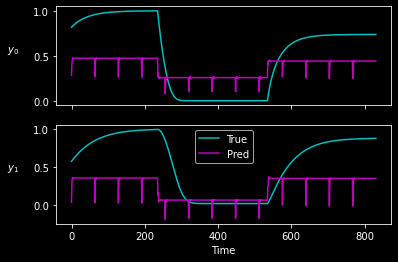

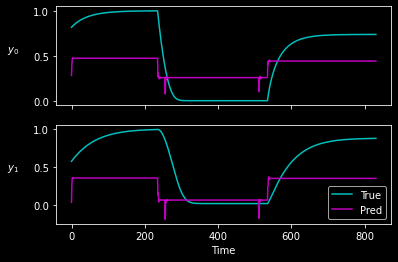

In [10]:
best_outputs = trainer.test(best_model)

In [11]:
logger.clean_up()

C:\Users\skom194\Anaconda3\envs\nm\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
